## Projeto de Mineração Estatística de Dados

Alunos:
- Dayvison
- Ednaldo
- Elayni
- Thiago
- Ítalo

Biblioetecas utilizadas

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.naive_bayes import GaussianNB

sns.set_style('whitegrid')

### Integração

Carregamos as bases da paraíba e de pernambuco e tiramos uma coluna desnecessária

In [8]:
df_pb = pd.read_csv('covid19-pb.csv')

In [9]:
df_pe = pd.read_csv('covid19-pe.csv')

In [10]:
df_pb = df_pb.drop(columns=['Unnamed: 0'])

In [11]:
df_pe = df_pe.drop(columns=['Unnamed: 0'])

Removendo linhas com valores faltantes para as cidades

In [12]:
df_pb = df_pb.dropna(subset=['city']).reset_index().drop(columns=['index'])
df_pe = df_pe.dropna(subset=['city']).reset_index().drop(columns=['index'])

Aqui fazemos a integração dos dados

In [13]:
df = pd.concat([df_pb, df_pe], axis=0).reset_index().drop(columns=['index'])

In [14]:
df

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,João Pessoa,2507507.0,2020-03-18,202012,817511.0,809015.0,False,False,1,0.12232,2020-03-18,0.0000,0,1,city,PB,1,0
1,João Pessoa,2507507.0,2020-03-19,202012,817511.0,809015.0,False,False,1,0.12232,2020-03-19,0.0000,0,2,city,PB,0,0
2,João Pessoa,2507507.0,2020-03-20,202012,817511.0,809015.0,False,False,1,0.12232,2020-03-20,0.0000,0,3,city,PB,0,0
3,João Pessoa,2507507.0,2020-03-21,202012,817511.0,809015.0,False,False,1,0.12232,2020-03-21,0.0000,0,4,city,PB,0,0
4,João Pessoa,2507507.0,2020-03-22,202013,817511.0,809015.0,False,False,1,0.12232,2020-03-22,0.0000,0,5,city,PB,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284135,Vicência,2616308.0,2022-03-27,202213,32772.0,32643.0,False,True,794,2422.79995,2021-10-22,0.0428,34,707,city,PE,0,0
284136,Vitória de Santo Antão,2616407.0,2022-03-27,202213,139583.0,138757.0,False,True,7407,5306.52013,2021-10-22,0.0440,326,720,city,PE,0,0
284137,Xexéu,2616506.0,2022-03-27,202213,14757.0,14725.0,False,True,624,4228.50173,2021-10-22,0.0449,28,704,city,PE,0,0
284138,Água Preta,2600401.0,2022-03-27,202213,37082.0,36771.0,False,True,1627,4387.57349,2021-10-22,0.0375,61,701,city,PE,0,0


Mudamos o tipo da data para um do pandas, usando o to_datetime

In [15]:
df['date'] = pd.to_datetime(df['date'])

Ordenamos os dados pela data

In [16]:
df = df.sort_values('date').reset_index().drop(columns=['index'])

### Limpeza

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284140 entries, 0 to 284139
Data columns (total 18 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   city                                           284140 non-null  object        
 1   city_ibge_code                                 282748 non-null  float64       
 2   date                                           284140 non-null  datetime64[ns]
 3   epidemiological_week                           284140 non-null  int64         
 4   estimated_population                           282748 non-null  float64       
 5   estimated_population_2019                      282748 non-null  float64       
 6   is_last                                        284140 non-null  bool          
 7   is_repeated                                    284140 non-null  bool          
 8   last_available_confirmed                    

Com base na info acima, escolhemos algumas colunas que não nos ajudariam para futuras análises

In [18]:
columns_to_drop = ['city_ibge_code', 'place_type', 'is_last', 'is_repeated','estimated_population_2019','last_available_date']

In [19]:
df = df.drop(columns=columns_to_drop)

Removemos linhas onde a cidade era 'Importados/Indefinidos'

In [20]:
df = df.drop(df[df['city'] == 'Importados/Indefinidos'].index).reset_index().drop(columns=['index'])

In [21]:
df.isnull().sum()

city                                               0
date                                               0
epidemiological_week                               0
estimated_population                               0
last_available_confirmed                           0
last_available_confirmed_per_100k_inhabitants    262
last_available_death_rate                          0
last_available_deaths                              0
order_for_place                                    0
state                                              0
new_confirmed                                      0
new_deaths                                         0
dtype: int64

Aqui preenchemos os valores faltantes em 'last_available_confirmed_per_100k_inhabitants' com sua mediana

In [22]:
df = df.fillna(value={'last_available_confirmed_per_100k_inhabitants': df['last_available_confirmed_per_100k_inhabitants'].median()})

In [23]:
df.isnull().sum()

city                                             0
date                                             0
epidemiological_week                             0
estimated_population                             0
last_available_confirmed                         0
last_available_confirmed_per_100k_inhabitants    0
last_available_death_rate                        0
last_available_deaths                            0
order_for_place                                  0
state                                            0
new_confirmed                                    0
new_deaths                                       0
dtype: int64

<AxesSubplot:>

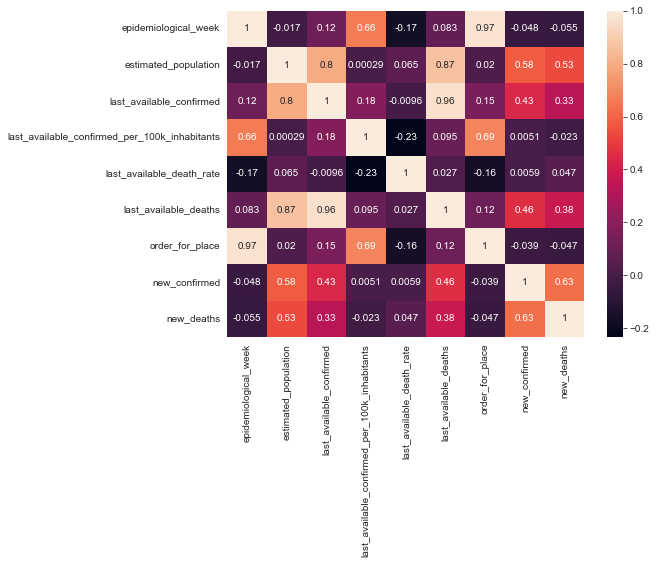

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)

Olhamos aqui a correlação e decidimos remover 'order_for_place'

In [25]:
df = df.drop(columns=['order_for_place'])

### Suavização dos dados

Fizemos uma espécie de binning com a coluna 'epidemiological_week_binning'

In [26]:
df['epidemiological_week_binning'] = df['epidemiological_week'].apply(lambda x: x - 202010)

In [27]:
df

,city,date,epidemiological_week,estimated_population,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths,epidemiological_week_binning
0,Recife,2020-03-12,202011,1653461.0,2,0.12096,0.0000,0,PE,2,0,1
1,Recife,2020-03-13,202011,1653461.0,2,0.12096,0.0000,0,PE,0,0,1
2,Recife,2020-03-14,202011,1653461.0,6,0.36288,0.0000,0,PE,4,0,1
3,Recife,2020-03-15,202012,1653461.0,7,0.42335,0.0000,0,PE,1,0,2
4,Recife,2020-03-16,202012,1653461.0,7,0.42335,0.0000,0,PE,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
282743,Gado Bravo,2022-03-27,202213,8303.0,777,9358.06335,0.0116,9,PB,0,0,203
282744,Guarabira,2022-03-27,202213,59115.0,10003,16921.25518,0.0146,146,PB,0,0,203
282745,Gurinhém,2022-03-27,202213,14127.0,948,6710.55426,0.0179,17,PB,0,0,203
282746,Marcação,2022-03-27,202213,8653.0,876,10123.65654,0.0114,10,PB,0,0,203


Tentamos usar a regressão mas não conseguimos ter resultados bons para uma suavização decente, então usamos a função log para suavizar

In [28]:
df['last_available_confirmed'] = df['last_available_confirmed'].apply(lambda x: 0 if x==0 else np.log(x))
df['last_available_confirmed_per_100k_inhabitants'] = df['last_available_confirmed_per_100k_inhabitants'].apply(lambda x: 0 if x==0 else np.log(x))
df['last_available_deaths'] = df['last_available_deaths'].apply(lambda x: 0 if x==0 else np.log(x))
df['state'] = df['state'].apply(lambda x: 1 if x=='PB' else 0)

In [29]:
df

,city,date,epidemiological_week,estimated_population,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths,epidemiological_week_binning
0,Recife,2020-03-12,202011,1653461.0,0.693147,-2.112295,0.0000,0.000000,0,2,0,1
1,Recife,2020-03-13,202011,1653461.0,0.693147,-2.112295,0.0000,0.000000,0,0,0,1
2,Recife,2020-03-14,202011,1653461.0,1.791759,-1.013683,0.0000,0.000000,0,4,0,1
3,Recife,2020-03-15,202012,1653461.0,1.945910,-0.859556,0.0000,0.000000,0,1,0,2
4,Recife,2020-03-16,202012,1653461.0,1.945910,-0.859556,0.0000,0.000000,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
282743,Gado Bravo,2022-03-27,202213,8303.0,6.655440,9.143994,0.0116,2.197225,1,0,0,203
282744,Guarabira,2022-03-27,202213,59115.0,9.210640,9.736326,0.0146,4.983607,1,0,0,203
282745,Gurinhém,2022-03-27,202213,14127.0,6.854355,8.811437,0.0179,2.833213,1,0,0,203
282746,Marcação,2022-03-27,202213,8653.0,6.775366,9.222630,0.0114,2.302585,1,0,0,203


<AxesSubplot:>

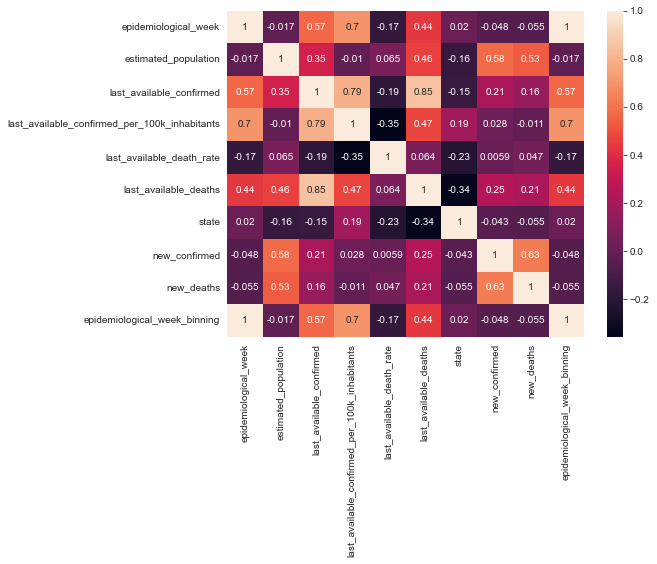

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)

Retiramos a coluna original após o binning

In [31]:
df = df.drop(columns=['epidemiological_week'])

In [32]:
df

,city,date,estimated_population,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths,epidemiological_week_binning
0,Recife,2020-03-12,1653461.0,0.693147,-2.112295,0.0000,0.000000,0,2,0,1
1,Recife,2020-03-13,1653461.0,0.693147,-2.112295,0.0000,0.000000,0,0,0,1
2,Recife,2020-03-14,1653461.0,1.791759,-1.013683,0.0000,0.000000,0,4,0,1
3,Recife,2020-03-15,1653461.0,1.945910,-0.859556,0.0000,0.000000,0,1,0,2
4,Recife,2020-03-16,1653461.0,1.945910,-0.859556,0.0000,0.000000,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
282743,Gado Bravo,2022-03-27,8303.0,6.655440,9.143994,0.0116,2.197225,1,0,0,203
282744,Guarabira,2022-03-27,59115.0,9.210640,9.736326,0.0146,4.983607,1,0,0,203
282745,Gurinhém,2022-03-27,14127.0,6.854355,8.811437,0.0179,2.833213,1,0,0,203
282746,Marcação,2022-03-27,8653.0,6.775366,9.222630,0.0114,2.302585,1,0,0,203


#### Redução de Dados

Usamos o PCA para reduzir a quantidade de colunas e agregamos no dataframe que tínhamos

In [33]:
pca = PCA(n_components=6)
X = pca.fit_transform(df[df.columns[2:]])

In [34]:
pca_df = pd.DataFrame(X, columns=[f'PCA_{i}' for i in range(X.shape[1])])

In [35]:
df_reduzido = pd.concat([df[['city','date']], pca_df], axis=1)

In [36]:
df_reduzido

,city,date,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,Recife,2020-03-12,1.618795e+06,-76.302072,-203.880589,18.446737,1.966962,-3.598755
1,Recife,2020-03-13,1.618795e+06,-76.267156,-205.879929,18.436611,1.977415,-3.563989
2,Recife,2020-03-14,1.618795e+06,-76.297444,-201.869802,17.198119,2.816320,-3.639600
3,Recife,2020-03-15,1.618795e+06,-75.240072,-204.849922,17.033631,2.945959,-3.588165
4,Recife,2020-03-16,1.618795e+06,-75.222614,-205.849592,17.028567,2.951186,-3.570782
...,...,...,...,...,...,...,...,...
282743,Gado Bravo,2022-03-27,-2.636256e+04,108.323291,1.407786,1.690374,0.361222,0.031445
282744,Guarabira,2022-03-27,2.444944e+04,108.957956,-4.868768,-1.548229,-0.552153,-0.026910
282745,Gurinhém,2022-03-27,-2.053856e+04,108.390912,0.685542,1.385639,-0.233543,0.031481
282746,Marcação,2022-03-27,-2.601256e+04,108.331881,1.365459,1.515506,0.360885,0.032814


### FP-Tree

No FP Tree deu problema, pois nossos dados não são bons para utilizar isso, eu peguei um código que deixa os dados do jeito que é necessário para utilizar a FP-Tree, com as saídas dos dataframes equivalentes, mas mesmo assim não funcionou.

In [37]:
df_teste = df[['city']]
df_teste["incident_count"] = 1
df_table = df_teste.groupby("city").sum().sort_values("incident_count", ascending=False).reset_index()

C:\Users\Dayvison\AppData\Local\Temp/ipykernel_11180/2937121498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste["incident_count"] = 1


In [38]:
df_table

,city,incident_count
0,Paulista,1403
1,Alagoinha,1401
2,Condado,1395
3,Quixaba,1389
4,Triunfo,1365
...,...,...
396,Mirandiba,639
397,São Domingos,636
398,Monte Horebe,622
399,Poço de José de Moura,621


In [39]:
transaction = []
for i in range(df_table.shape[0]):
    transaction.append([str(df_table.values[i,j]) for j in range(df_table.shape[1])])

# creating the numpy array of the transactions
transaction = np.array(transaction)

# importing the required module
from mlxtend.preprocessing import TransactionEncoder

# initializing the transactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transaction).transform(transaction)
dataset = pd.DataFrame(te_ary, columns=te.columns_)

# dataset after encoded
dataset.head()

,1350,1355,1365,1389,1395,1401,1403,621,622,636,...,Vicência,Vieirópolis,Vista Serrana,Vitória de Santo Antão,Várzea,Xexéu,Zabelê,Água Branca,Água Preta,Águas Belas
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [40]:
dataset

,1350,1355,1365,1389,1395,1401,1403,621,622,636,...,Vicência,Vieirópolis,Vista Serrana,Vitória de Santo Antão,Várzea,Xexéu,Zabelê,Água Branca,Água Preta,Águas Belas
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
397,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
398,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
399,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [41]:
first30 = df_table["city"].head(30).values 

dataset = dataset.loc[:,first30] 

dataset.shape

(401, 30)

In [42]:
from mlxtend.frequent_patterns import fpgrowth

#running the fpgrowth algorithm
res = fpgrowth(dataset ,min_support=0.05, use_colnames=True)

# printing top 10
res

,support,itemsets


### Clusterização

K-Means

Para o K-Means, focamos em fazer 2 grupos, que seriam os dois estados, para ver se ele conseguiria dizer que entrada de dados é de qual estado.

In [43]:
le = preprocessing.LabelEncoder()
city = le.fit_transform(df['city'])

In [44]:
df['city'] = city

In [45]:
df.head()

,city,date,estimated_population,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths,epidemiological_week_binning
0,281,2020-03-12,1653461.0,0.693147,-2.112295,0.0,0.0,0,2,0,1
1,281,2020-03-13,1653461.0,0.693147,-2.112295,0.0,0.0,0,0,0,1
2,281,2020-03-14,1653461.0,1.791759,-1.013683,0.0,0.0,0,4,0,1
3,281,2020-03-15,1653461.0,1.945910,-0.859556,0.0,0.0,0,1,0,2
4,281,2020-03-16,1653461.0,1.945910,-0.859556,0.0,0.0,0,0,0,2


In [46]:
df.corr()['state']

city                                             0.008217
estimated_population                            -0.157372
last_available_confirmed                        -0.148714
last_available_confirmed_per_100k_inhabitants    0.190137
last_available_death_rate                       -0.227802
last_available_deaths                           -0.344318
state                                            1.000000
new_confirmed                                   -0.042711
new_deaths                                      -0.054578
epidemiological_week_binning                     0.019618
Name: state, dtype: float64

In [47]:
kmeans = KMeans(n_clusters=2)

In [48]:
pred = kmeans.fit_predict(df.drop(columns=['city','date','state']).values)

In [49]:
pred = kmeans.fit_predict(df['city'].values.reshape(-1,1))

Ele não se saiu muito bem como vemos abaixo

In [50]:
np.mean( pred == df['state'] )*100

45.90094359641801

Árvore de decisão

In [51]:
clf = DecisionTreeClassifier(random_state=0, max_depth=5)

In [52]:
df.head()

,city,date,estimated_population,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths,epidemiological_week_binning
0,281,2020-03-12,1653461.0,0.693147,-2.112295,0.0,0.0,0,2,0,1
1,281,2020-03-13,1653461.0,0.693147,-2.112295,0.0,0.0,0,0,0,1
2,281,2020-03-14,1653461.0,1.791759,-1.013683,0.0,0.0,0,4,0,1
3,281,2020-03-15,1653461.0,1.945910,-0.859556,0.0,0.0,0,1,0,2
4,281,2020-03-16,1653461.0,1.945910,-0.859556,0.0,0.0,0,0,0,2


In [53]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['date','state','city']), df['state'])

In [54]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [55]:
y_pred = clf.predict(X_test)

Temos um bom resultado predizendo o estado

In [56]:
print(classification_report(y_test, y_pred, target_names=['PE','PB']))

              precision    recall  f1-score   support

          PE       0.86      0.76      0.81     32575
          PB       0.82      0.89      0.85     38112

    accuracy                           0.83     70687
   macro avg       0.84      0.83      0.83     70687
weighted avg       0.84      0.83      0.83     70687



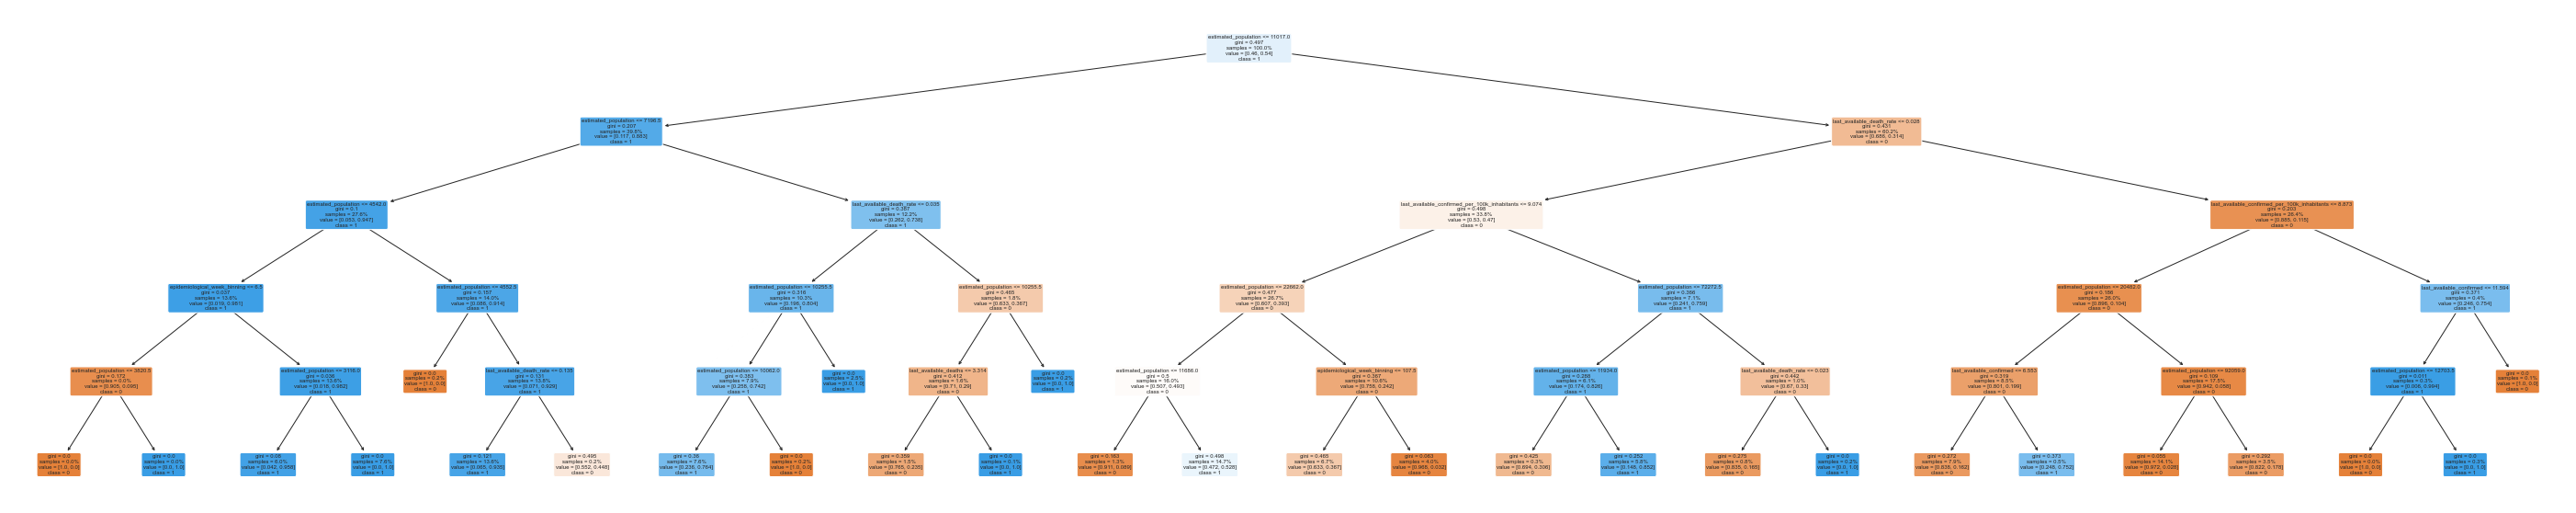

In [57]:
class_label = ['0','1']

plt.figure(figsize=(50,10))
plot_tree(
    clf, 
    feature_names = X_train.columns,
    class_names = class_label, 
    filled=True, 
    proportion = True,
    fontsize=6, 
    rounded = True)

plt.savefig('arvore.png')
plt.show()

In [58]:
features = df.drop(columns=['date','state','city']).columns.to_list()

Aqui vemos quais colunas foram mais importantes

In [59]:
for feature, value in zip(features, clf.feature_importances_):
    print(f'{feature}: {value}')

estimated_population: 0.7184680636860525
last_available_confirmed: 0.018336985317452127
last_available_confirmed_per_100k_inhabitants: 0.06825249581441824
last_available_death_rate: 0.16923980982708442
last_available_deaths: 0.004724183972653684
new_confirmed: 0.0
new_deaths: 0.0
epidemiological_week_binning: 0.02097846138233911


In [60]:
scores_cross = cross_val_score(clf, df.drop(columns=['date','state','city']), df['state'], cv=10)

Validação cruzada e a média

In [61]:
scores_cross

array([0.64364279, 0.81877984, 0.8225641 , 0.80222812, 0.79837312,
       0.81913351, 0.83908046, 0.8441733 , 0.84420315, 0.8438141 ])

In [62]:
scores_cross.mean()

0.8075992502820855

Naive de Bayes

In [63]:
naive = GaussianNB()

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['date','state','city']), df['state'])

In [65]:
naive.fit(X_train, y_train)

GaussianNB()

In [66]:
y_pred = naive.predict(X_test)

Também temos um resultado bom com o naive bayes

In [67]:
print(classification_report(y_test, y_pred, target_names=['PE','PB']))

              precision    recall  f1-score   support

          PE       0.73      0.07      0.12     32587
          PB       0.55      0.98      0.71     38100

    accuracy                           0.56     70687
   macro avg       0.64      0.52      0.41     70687
weighted avg       0.63      0.56      0.44     70687



In [68]:
scores_cross = cross_val_score(naive, df.drop(columns=['date','state','city']), df['state'], cv=10)

In [69]:
scores_cross

array([0.55982317, 0.55865606, 0.55720601, 0.55943413, 0.5603183 ,
       0.56657825, 0.5596817 , 0.55833775, 0.5574733 , 0.55761477])

In [70]:
scores_cross.mean()

0.5595123433707048

Aqui é a curva roc da árvore de decisão

C:\Users\Dayvison\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


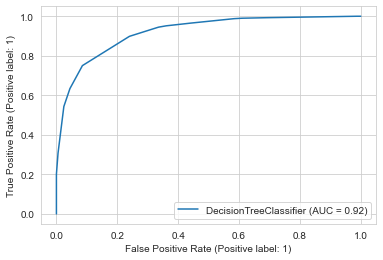

In [71]:
plot_roc_curve(clf, X_test, y_test, pos_label=1)
plt.show()

Curva roc do naive bayes

C:\Users\Dayvison\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


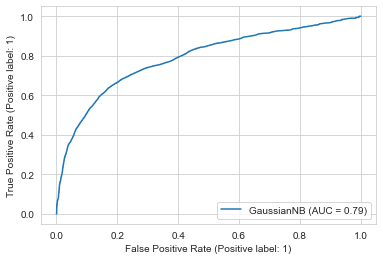

In [72]:
plot_roc_curve(naive, X_test, y_test, pos_label=1)
plt.show()